In [2]:
import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from shapely import Polygon,Point,MultiPoint,LineString
from scipy.spatial import ConvexHull
from itertools import combinations
from shapely.ops import unary_union
from IPython.display import display, clear_output
from matplotlib import animation
from sympy import symbols
import numpy.matlib
import matplotlib.colors as mcolors
import shapely as shapely
import random
import pandas as pd
def getPotRegions(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp, X[i][1]+imp]
        Bx[i,1,:]= [X[i][0]+imp, X[i][1]+imp]
        Bx[i,2,:]= [X[i][0]+imp, X[i][1]-imp]
        Bx[i,3,:]= [X[i][0]-imp, X[i][1]-imp]
    return(Bx);
def getPotRegions_var(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [X[i][0]-imp[i], X[i][1]+imp[i]]
        Bx[i,1,:]= [X[i][0]+imp[i], X[i][1]+imp[i]]
        Bx[i,2,:]= [X[i][0]+imp[i], X[i][1]-imp[i]]
        Bx[i,3,:]= [X[i][0]-imp[i], X[i][1]-imp[i]]
    return(Bx);
def getPotRegions_var2(X,imp):
    Bx= np.zeros((len(X),4,2));
    for i in range(len(X)):
        Bx[i,0,:]= [float(X[i][0]-imp[i]), float(X[i][1]+imp[i])]
        Bx[i,1,:]= [float(X[i][0]+imp[i]), float(X[i][1]+imp[i])]
        Bx[i,2,:]= [float(X[i][0]+imp[i]), float(X[i][1]-imp[i])]
        Bx[i,3,:]= [float(X[i][0]-imp[i]), float(X[i][1]-imp[i])]
    return(Bx);
def CPIH_Safepoint(n,Bx,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);

    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
    CPIH= Polygon();
    #testing
   
    for C in combk:
        if Xi in C:
            comb3 = list(combinations(C,3));
            dp1 =[];
            Chull = Polygon();
            for i in range(len(comb3)):
                comb2 = list(combinations(comb3[i][:],2))
                b1 = int(comb3[i][0]);
                b2 = int(comb3[i][1]);
                b3 = int(comb3[i][2]);
                dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
                idx = ConvexHull(dp1);
                dp1 = Polygon(dp1[idx.vertices,:]);
                dp2 = Polygon();
                for j in range(len(comb2)):
                    a1 = comb2[j][0];
                    a2 = comb2[j][1];
                    temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
                    idx = ConvexHull(temp);
                    temp =  Polygon(temp[idx.vertices,:]);
                    dp2 = unary_union([dp2,temp])
                diff = dp1.difference(dp2);
                Chull= unary_union([Chull,diff]);


            if (first and not Chull.is_empty):
                CPIH = Polygon(Chull.convex_hull);

            else:
                #NEW 
                if not Chull.is_empty:
                    Chull = Polygon(Chull.convex_hull);
                #ENDNEW
                CPIH = CPIH.intersection(Chull);
                if not CPIH.geom_type == 'Polygon' and not CPIH.is_empty:

                    for member in CPIH.geoms:
                        if member.geom_type == 'Polygon':
                            CPIH = member;


                if CPIH.is_empty:
                    return [0,0];
                    break;
            first = False;
    safeX,safeY = np.array(CPIH.exterior.xy)
        #safeX.append(x);
        #safeY.append(y);
    return [safeX,safeY];
    #return CPIH
def maxDist(Xi,safeX,safeY):
    max_dist = 0;
    max_indx = [];
    for i in range(len(safeX)):
        norm = np.linalg.norm(Xi-[safeX[i],safeY[i]]);
        if norm> max_dist:
            max_dist = norm;
            max_indx = [];
            max_indx.append(i);
        elif norm == max_dist:
            max_indx.append(i);
            
    return [np.mean(safeX[max_indx]),np.mean(safeY[max_indx])],max_dist;
def minOrthProj(Xi,Xj,X,f):
    JI = Xj-Xi;
    mindist = 100;
    for i in range(len(X)-f):
        if any(X[i] != Xi) and any(X[i] != Xj):
            AB = X[i]-Xi;
            
            AB_orth = np.array([-AB[1],AB[0]]);
            alt = np.linalg.norm(np.dot(AB_orth,JI)/pow(np.linalg.norm(AB_orth),2)*AB_orth);
            if alt < mindist:
                mindist = alt;
    return mindist;

def get_colors(n,f):
    colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
    for attacker in range(f):
        colors.append('r')
    return colors
def ExtractX(lst,i):
    return [item[i][0] for item in lst]
def ExtractY(lst,i):
    return [item[i][1] for item in lst]

def plothull(X):
    hull = ConvexHull(X);
    hullx = np.append(X[hull.vertices,0],X[hull.vertices[0],0]);
    hully = np.append(X[hull.vertices,1],X[hull.vertices[0],1]);
    plt.plot(hullx,hully);
def calcsafepoint(n,Bx):
    n = np.arange(n);
    comb3 = list(combinations(n,3));
    safeX = [];
    safeY =[];
    dp1 =[]
    for i in range(len(comb3)):
        comb2 = list(combinations(comb3[i][:],2))
        b1 = int(comb3[i][0]);
        b2 = int(comb3[i][1]);
        b3 = int(comb3[i][2]);
        dp1 = np.vstack((Bx[b1,:,:],Bx[b2,:,:],Bx[b3,:,:]));
        idx = ConvexHull(dp1);
        dp1 = Polygon(dp1[idx.vertices,:]);
        dp2 = Polygon();
        for j in range(len(comb2)):
            a1 = comb2[j][0];
            a2 = comb2[j][1];
            temp= np.vstack((Bx[a1,:,:],Bx[a2,:,:]));
            idx = ConvexHull(temp);
            temp =  Polygon(temp[idx.vertices,:]);
            dp2 = unary_union([dp2,temp])
        diff = dp1.difference(dp2);
        x,y = np.array(diff.exterior.xy)
        safeX.append(x);
        safeY.append(y);
    return [safeX,safeY]; 
def DBCPIH(n,Xn,Xi):
    k = int(np.floor(2/3*n)+1);
    n = np.arange(n);
    DBCPIH= Polygon();
    combk = list(combinations(n,k));
    safeX = [];
    safeY =[];
    first= True;
  
    for C in combk:
        v =[]
        comb3 = list(combinations(C,3));
        for i in range(len(comb3)):
            safePoint = 1/3*(Xn[comb3[i][0]][:]+Xn[comb3[i][1]][:]+Xn[comb3[i][2]][:]);
            v.append(safePoint)
        v_empty = True
        
        for array in v:
            if v_empty:
                temp = array
                v_empty = False
            else:
                temp= np.vstack((temp,array));
      
        idx = ConvexHull(temp)
      
        Chull  = Polygon(temp[idx.vertices][:])
        if (first and DBCPIH.is_empty):
                DBCPIH = Polygon(Chull.convex_hull);
                first = False;
        else:
            DBCPIH = DBCPIH.intersection(Chull)
           
    if DBCPIH.geom_type == 'Polygon':
        safeX,safeY = np.array(DBCPIH.exterior.xy)
        return np.array((np.mean(safeX), np.mean(safeY)))
    elif DBCPIH.geom_type == 'Point':
        try:
            safeX,safeY = [DBCPIH.x, DBCPIH.y];
        except:
            safeX,safeY = np.array((0,0))
        print(np.array((safeX,safeY)))
        return np.array((safeX,safeY)).T
def getCenterpoint(n,X,i):
    size = int(np.floor(2*n/3)+1)
    n = np.arange(n);
    
    combk = list(combinations(n,size));
    safeX = [];
    safeY =[];
    dp1 =[]
    first = True;
    success = True;
    safeHull = Polygon();
    for comb in combk:
        Xc= np.zeros((size,2));
        j = 0;
        for idx in comb:
            Xc[j,:] = X[idx,:];
            j+=1;
        hullk = ConvexHull(Xc);
         
        dp1 = Polygon(Xc[hullk.vertices,:]);
        if safeHull.is_empty:
            safeHull = dp1;
        try:
            safeHull = safeHull.intersection(dp1);
        except:
            print("could not compute centerpoint for ",X)
            safeHull = safeHull
            success = False
    if safeHull.geom_type == 'Polygon':
        safeX,safeY = np.array(safeHull.exterior.xy)
        if safeX.size == 0  or safeY.size== 0:
            safeX = 0
            safeY = 0
        return[safeX,safeY]
    elif safeHull.geom_type == 'LineString' or safeHull.geom_type == "Point":
        safepoints = np.array(shapely.get_coordinates(safeHull).tolist())
        safeX = safepoints[:,0]
        safeY = safepoints[:,1]
    elif safeHull is None:
        return [0,0]
    else:
        return [0,0]
def attackerTarget(X):
    n = (int)(np.floor(len(X)/2))
    oriented = False
    deg =0
    while not oriented:
        if deg == 0:
            inc = 10
        rounds = np.floor(deg/360)+1
        inc = inc/rounds
        X = X[X[:,0].argsort()]
        left = X[0:n]
        right = X[n: ]
        lminidx = np.argmin(left[:,1])
        rminidx = np.argmin(right[:,1])
        xc_idx = np.argmin(X[:,1])
        
        if xc_idx == n:
            oriented = True
        else:
            X = rotate(X,10)
            deg+=inc
            
    
    lmin = left[lminidx][1]
    rmin = np.min(right[:,1])
    ymin = np.min([lmin,rmin])

    n_left = len(left)-1
    n_right = len(right)
    lastleft = left[len(left)-1]
    firstright = right[1]
    for i in range(n_left):
        l = left[i]
        if l[0] == left[n_left][0] and l[1]>left[n_left][1]:
            lastleft = l
    for i in range(1,n_right):
        if right[i][0] == right[0][0] and right[i][1]>right[0][1]:
            firstright = right[i]
        
   
    xp =  (left[len(left)-1][0]+right[0][0])/2
    #point = np.array((xp,ymin-2))
    point = X[n]+np.array((0,-2))
    lvec = (lastleft[1]-point[1])/(lastleft[0]-point[0])
    rvec = (firstright[1]-point[1])/(firstright[0]-point[0])
    lvec = np.array([-np.sign(lvec),-1*np.abs(lvec)])
    rvec = np.array([-np.sign(rvec),-1*np.abs(rvec)])
    lvec = lvec/np.linalg.norm(lvec)
    rvec = rvec/np.linalg.norm(rvec)
    offset = np.random.random()
    #lvec = np.array([-np.sign(lvec),-1*np.abs(lvec)])
    #rvec = np.array([-np.sign(rvec),-1*np.abs(rvec)])
    point2 = point+[-np.sign(lvec),-1*np.abs(lvec)]+[-np.sign(rvec),-1*np.abs(rvec)]
    point3 = np.array(point+offset*lvec+(1-offset)*rvec)
    angle_rad = np.radians(-deg)
    centroid = np.mean(X, axis=0)

    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    # Translate points to the origin (subtract centroid)
    translated_point = point3 - centroid

    # Rotate points
    rotated_point = np.dot(translated_point, rotation_matrix.T)

    # Translate points back (add centroid)
    rotated_point += centroid
    return rotated_point
def rotate(points, angle_deg):

    # Convert the angle to radians
    angle_rad = np.radians(angle_deg)

    # Calculate the centroid
    centroid = np.mean(points, axis=0)

    # Create the rotation matrix
    rotation_matrix = np.array([
        [np.cos(angle_rad), -np.sin(angle_rad)],
        [np.sin(angle_rad), np.cos(angle_rad)]
    ])

    # Translate points to the origin (subtract centroid)
    translated_points = points - centroid

    # Rotate points
    rotated_points = np.dot(translated_points, rotation_matrix.T)

    # Translate points back (add centroid)
    rotated_points += centroid

    return rotated_points
                         

C:\Users\85chr\AppData\Local\Temp\ipykernel_31764\196476881.py:128: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = [plt.cm.get_cmap('viridis',n-f)(i) for i in range(n-f)];
C:\Users\85chr\AppData\Local\Temp\ipykernel_31764\2457655750.py:83: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);
C:\Users\85chr\anaconda3\Lib\site-packages\shapely\set_operations.py:131: RuntimeWarning: divide by zero encountered in intersection
  return lib.intersection(a, b, **kwargs)


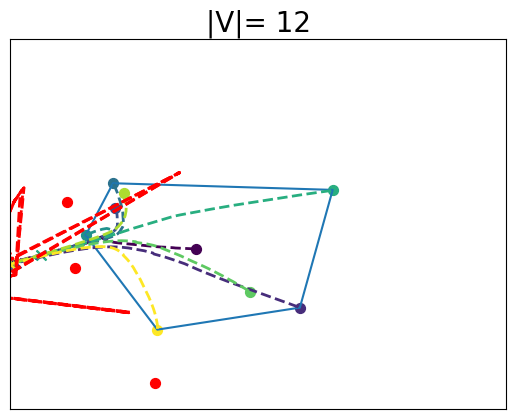

In [6]:
for trial in range(1):
    fig, ax = plt.subplots()
    #fig2,ax2 = plt.subplots()

    n = 12
    offset = np.ones((n,2))*.5;
    X= 10*(np.random.rand(n,2)-offset)
    #n = 6
    #for i in range(n):
    #    theta = 2*np.pi/(n)*i
    #    X[i] = np.array((5*np.cos(theta),5*np.sin(theta)))
    #X = np.array([(-3,-1), (-3, 4),(0.5 ,-4),(1.5,6),(3.5,2),(4,-1)]);
    #X[n-1]= np.array((5,1))
    attackers = [n-1]
    if n >6:
        #X[n-2] = np.array((6,-1))
        attackers = [n-2,n-1]
    if n>9:
       # X[n-3] = np.array((7,-3))
        attackers = [n-3,n-2,n-1];
    attackmode = 2
    attackerTargetHist = []
    attackerTargetHist.append([])
    attackerTargetHist.append([])
    attackerTargetHist.append([])
    Xn = np.zeros((n,9,2));
    #Xn = np.zeros((8,8,2))
    N = []
    nh = nh = random.sample(range(n-3),6)
    nh.append(9)
    nh.append(10)
    nh.append(11)
    N.append(nh)
    for i in range(1,n):

        nh = random.sample(range(n-3),7)
        advnh = random.sample(range(n-3,n),2)
        nh.append(advnh[0])
        nh.append(advnh[1])
        #for attacker in attackers:
         #   nh.append(attacker)

        N.append(nh)
        Xn[i][:] = X[N[i]]
    f = len(attackers);
    #imp = .5*np.ones((6,6))-.5*np.eye(6);
    imp = 0.5;
    colors= get_colors(n,f);
    empty = False;


    frames = [];
    step = 0;
    emptyCPIH = np.zeros((n,1));
    Xhist = [];
    Yhist = [];
    hull = ConvexHull(X[0:n-f]);
    xplot = [];
    yplot = [];
    ham = 0;
    #attackerTarget = [np.array((6,6)),np.array((6,6)),np.array((6,-6))]
    Bx = getPotRegions(X,imp);
    imprecision = False
    if imprecision:
        for j in range(n):
                x = []; y = [];
                for k in range(4):
                    x.append(Bx[j,k,0]);
                    y.append(Bx[j,k,1]);
                x.append(Bx[j,0,0]);
                y.append(Bx[j,0,1]);
                    #ax.scatter(x,y)
                ax.plot(x,y,c= colors[j]);
    imp = 0
    for v in hull.vertices:
        xplot.append(X[v,0]);
        yplot.append(X[v,1]);
    xplot.append(X[hull.vertices[0],0]);
    yplot.append(X[hull.vertices[0],1]);
    ax.plot(xplot,yplot,label = 'Conv('+r'$X_0$'+')');
    for i in range(n-f):
        lbl = r'$v_{s1}$'.replace('s1',str(i+1));
        ax.scatter(X[i,0],X[i,1],c= colors[i], marker = 'o',label = lbl,s =50);

    for idx in attackers:
        lbl = r'$v_f$'#+str(attackers.index(idx)+1);
        ax.scatter(X[idx,0],X[idx,1],c= colors[idx], marker = 'o',label = lbl,s = 50);
    maxdist = np.zeros((1,602))
    target = np.zeros((n,2));
    targetdist=np.zeros((n,1));
    snapshot= (0,80,160,240,300,600)
    imphist = [];
    tm = []
    attackedHood = [[],[],[]]
    while not empty:

        #ax.cla();
       # ax.set_xlim(-7,7);
       # ax.set_ylim(-7,7);
        dt = .01;
        n = len(X);

        safeX= [];
        safeY=[];
        dist = 0;

        for i in range(n):
            if i not in attackers or attackmode == 0:
                        Xn[i][:] = X[N[i]]#X+np.matlib.repmat(a,6,1);
            if i not in attackers:
                #safeX,safeY = CPIH_Safepoint(n,Bx,i);
                try:
                    safeX,safeY = getCenterpoint(9,Xn[i],i);
                    #print("safeX:",safeX, " safeY:", safeY)
                    target[i] = [np.mean(safeX), np.mean(safeY)]
                    #theta = 2*np.pi/(n)*i
                    #target[i] = np.array((5*(1/step)*np.cos(theta),5*(1/step)*np.sin(theta)))
                    #print("agent",i," has safepoint:",np.mean(safeX),", ",np.mean(safeY))
                except Exception as e:
                    print("An exception occurred:", type(e).__name__)
                    safeX,safeY = [0,0]
                    print("no Safepoints")
                #CPIH = CPIH_Safepoint(n,Bx);
                #safeX,safeY = optConfig(Xn[i],i,imp);
                #if (isinstance(safeX,int) and isinstance(safeY,int)) or safeX.size ==0:
                    #print('CPIH empty');
                    #empty = True;
                 #   emptyCPIH[i] = 1;
                  #  target[i] = X[i]
                #else:
                    target[i] = X[i];


                   # emptyCPIH[i] =1;

            elif i in attackers:
                if attackmode == 0:
                    try:
                        safeX,safeY = getCenterpoint(9,Xn[i],i);
                        target[i] = [np.mean(safeX), np.mean(safeY)]
                    except Exception as e:
                        print("An exception occurred:", type(e).__name__)
                        safeX,safeY = [0,0]
                        print("no Safepoints")
                if attackmode == 1:
                    target[i] = X[i]
                if attackmode == 2:
                    firstfound = False
                    used = []
                    for j in range(len(N)):
                        if not firstfound:# and j not in used:
                            for k in range(len(N[j])):
                                if N[j][k] == i:
                                    used.append(j)
                                    #temp = np.delete(X[N[j]],k, axis = 0)
                                    norm_idx = N[j][0:6]
                                    temp = X[norm_idx]
                                    target[i]= attackerTarget(temp)
                                    firstfound = True
                                    attackerTargetHist[attackers.index(i)].append(target[i])
                                    attackedHood[attackers.index(i)].append(j)
               # target[i] = attackerTarget[attackers.index(i)];




        for i in range(n):
            X[i]= X[i]+dt*(target[i]-X[i]);
        for i in attackers:
            if attackmode == 0:
                X[i] = X[i]+dt*(target[i]-X[i]);
            else:
                X[i] = target[i]
        Xhist.append(X.copy());

        if step>600:
            empty = True;


        for i in range(n-len(attackers)):
            for j in range(n-len(attackers)):
                temp = np.linalg.norm(X[i]-X[j]);
                if temp> maxdist[0][step]:
                    maxdist[0][step] = temp;
        step +=1;

    for i in range(n):
        xplot = ExtractX(Xhist,i);
        yplot = ExtractY(Xhist,i);
        endn = len(xplot);
        ax.plot(xplot,yplot,c = colors[i],linestyle='dashed',linewidth= 2);
        ax.scatter(xplot[endn-1],yplot[endn-1],c = colors[i], marker='x',s=50);
    ax.set_xlim(-6,9);
    ax.set_ylim(-6,9);
    ax.set_xticks([])
    ax.set_yticks([])
    plt.title('|V|= '+str(n),fontsize = 20);
    plt.savefig("Centerpoint_trajectories_n"+str(n)+"_f"+str(f)+".jpg")
    saveData(Xhist,N,trial)

In [4]:
def saveData(Xhist,N,trial):
    for k in range(9):
        temp = Xhist[0][N[k]]
        for i in range(1,len(Xhist)):
            temp = np.vstack((temp,Xhist[i][N[k]]))
        df = pd.DataFrame(temp)
        df.to_csv(f"D:\School\Cirens\Xhist_trial_{trial}_v{k}.csv")

Rdata_t0_v0.csv
Rdata_t0_v1.csv
Rdata_t0_v2.csv
Rdata_t0_v3.csv
Rdata_t0_v4.csv
Rdata_t0_v5.csv
Rdata_t0_v6.csv
Rdata_t0_v7.csv
Rdata_t0_v8.csv


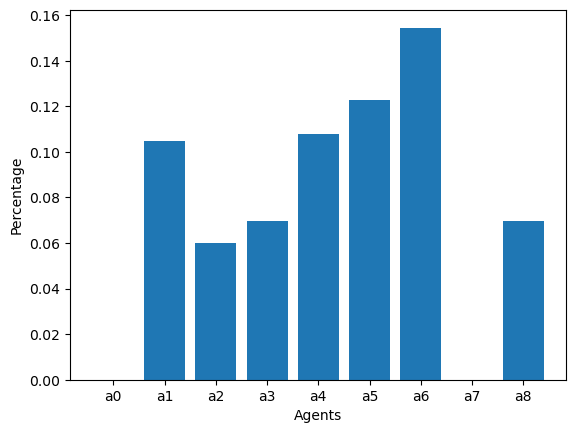

In [31]:
Rdata = []
for t in range(1):
    Rdata = []
    for i in range(9):
        df = pd.read_csv(f"Rdata_t{t}_v{i}.csv")
        print(f"Rdata_t{t}_v{i}.csv")
        df_clean = df.iloc[:,1:]
        Rdata.append(df_clean.values)
    for i in range(len(Rdata)):
        for j in range(len(Rdata[i])):
            for k in range(len(Rdata[i][j])):
                if Rdata[i][j][k] == -1:
                    Rdata[i][j][k] =3
    saveplots(Rdata,t)

In [30]:
def saveplots(Rdata,t):
    fig,ax = plt.subplots()

    n = 12
    f = 3
    x = np.arange(602)

    #for i in range(9):
    #    ax.plot(x,Rtm[i], c = colors[i])
    i = 8
    for i in range(9):
        ax.clear()
        ax.plot(x,Rdata[i], c = colors[i])
        plt.title('|V|= '+str(12)+', AttackMode = 3',fontsize = 20);
        plt.savefig("TukeyMedian_a"+str(i)+"_f"+str(f)+"mode3"+".jpg")
    percent = []
    for i in range(9):
        fourtime = 0
        for j in range(len(Rdata[i])):

            if Rdata[i][j]== 4:
                fourtime+=1
        percent.append(fourtime/602)
    agents = ['a0','a1','a2','a3','a4','a5','a6','a7','a8']
    plt.clf()
    plt.bar(agents,percent)
    plt.ylabel("Percentage")
    plt.xlabel("Agents")
    plt.savefig(f"Percentage_Bar_t{t}.jpg")